In [1]:
import numpy as np
import pandas as pd
import librosa

import os
import time
import re
from tqdm import tqdm
import h5py

import tensorflow as tf
from tensorflow.keras.utils import to_categorical, plot_model

import matplotlib.pyplot as plt
import IPython.display
import librosa.display

# Use GPU
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1654345441091751605
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 2258960090631250021
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7046801664
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4235852199305526771
physical_device_desc: "device: 0, name: GeForce GTX 1070, pci bus id: 0000:01:00.0, compute capability: 6.1"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 11328138101281914130
physical_device_desc: "device: XLA_GPU device"
]


## Loading Functions

In [2]:
# Load saved data
def Load_Augmented(name='', path='Augmented_Data/'):
    '''
        Input:
            name:      name of the file
            path:      path of the file
        
        Output:
            dataset:   loaded dataset with data and labels
    '''
    hf = h5py.File(path + name + '.h5', 'r')
    data =  np.array(hf.get('data'))
    labels = np.array(hf.get('label'))
    hf.close()
    
    data = np.asarray(data, dtype=np.float32)
    label = np.asarray(labels, dtype=np.float32)
    '''
    dataset = []
    for i in range(len(data)):
        dataset.append([data[i], labels[i]])
    
    dataset = np.asarray(dataset, dtype=object)
    '''
    return data, labels


def Preprocessing(raw_audio, labels, bands=60, frames=41):
    '''
        Input:
            raw_audio:     list that contains the raw/augmented data
            labels:        list that contains the category information
            bands:         number of mel band to use
            frames:        number of frames to use
        
        Output:
            features:      numpy array that contains processed audio data with log-melspec and delta
            new_labels:    new labels for each augmented segment
    '''    
    
    new_labels = []
    augmented_spec = []
    
    # Normalize the raw data
    norm_factor = np.percentile(raw_audio, 99) - np.percentile(raw_audio, 5)
    raw_audio = raw_audio / norm_factor
    
    # Loop over each file audio
    for num, audio in enumerate(tqdm(raw_audio)):
    
        # Convert audio to melspectogram
        '''
            With default n_fft=2048 we have the filter size of 2048/2+1=1025 [Nyquist Frequency]
        '''
        melspec = librosa.feature.melspectrogram(audio, n_mels=bands, hop_length=512)
        
        # Convert melspec to log melspec
        logspec = librosa.core.amplitude_to_db(melspec)
        
        counter = 0
        # Spectrogram splitting with 50% overlap and adapt cv-fold and labels info
        for idx in range(0, len(logspec[0]) - frames, int(frames/2)):
            augmented_spec.append(logspec[:, idx:idx+frames])
            new_labels.append(labels[num])
            counter = counter +1
            
    # Reshape the outputs
    log_specgrams = np.asarray(augmented_spec).reshape(len(augmented_spec), bands, frames, 1)
    features = np.concatenate((log_specgrams, np.zeros(np.shape(log_specgrams))), axis=3)
    new_labels = np.asarray(new_labels)
    
    # Fill the delta features
    for i in range(len(log_specgrams)):
        features[i, :, :, 1] = librosa.feature.delta(features[i, :, :, 0])
    
    features = features.astype(np.float64)
    labels = labels.astype(np.float32)
    return features, new_labels



def CreateTrainingSet(f1, f2, f3, lf1, lf2, lf3, batch_size=32):
    
    # Create training set
    merged_training_data = np.concatenate((f1, f2, f3))
    merged_training_label = np.concatenate((lf1, lf2, lf3))

    # Create and cache training
    training_dataset = tf.data.Dataset.from_tensor_slices((merged_training_data, merged_training_label))
    training_dataset = training_dataset.batch(batch_size=batch_size)
    training_dataset = training_dataset.cache("training_cache")
    training_dataset = training_dataset.prefetch(buffer_size=1)
    
    return training_dataset



def CreateValidationSet(f1, lf1, batch_size=32):

    # Create and cache training
    validation_dataset = tf.data.Dataset.from_tensor_slices((f1, lf1))
    validation_dataset = validation_dataset.cache("validation_cache")
    validation_dataset = validation_dataset.batch(batch_size=batch_size)
    validation_dataset = validation_dataset.prefetch(buffer_size=1)
    
    return validation_dataset

## Model Functions

In [3]:
def BackBoneNet(input_shape):
    
    X_input = tf.keras.Input(input_shape)
    
    # First branch with basic 3x3 kernel
    model = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), strides=2, padding='same', name='b1_conv0')(X_input)
    model = tf.keras.layers.BatchNormalization(axis=3)(model)
    model = tf.keras.layers.Activation('relu')(model)
    
    # Second branch with two stacked 3x3 kernel should equal to a single 9x9 from the original input
    '''
    branch_2 = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='same', name='b2_conv0')(X_input)
    branch_2 = tf.keras.layers.BatchNormalization(axis=3)(branch_2)
    branch_2 = tf.keras.layers.Activation('relu')(branch_2)
    branch_2 = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), strides=(2, 2), padding='same', name='b2_conv1')(branch_2)
    branch_2 = tf.keras.layers.BatchNormalization(axis=3)(branch_2)
    branch_2 = tf.keras.layers.Activation('relu')(branch_2)
    '''
    
    # Third branch with stacked dilated kernel
    branch_3 = tf.keras.layers.Conv2D(64, kernel_size=(5, 5), dilation_rate=(2, 2), padding='same', name='b3_conv0')(X_input)
    branch_3 = tf.keras.layers.BatchNormalization(axis=3)(branch_3)
    branch_3 = tf.keras.layers.Activation('relu')(branch_3)
    branch_3 = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), strides=2, padding='same', name='sdc_conv')(branch_3)

    # Fifth branch with stacked dilated kernel
    '''
    branch_4 = tf.keras.layers.Conv2D(32, kernel_size=(5, 5), dilation_rate=(4, 4), padding='same', name='b5_conv0')(X_input)
    branch_4 = tf.keras.layers.BatchNormalization(axis=3)(branch_4)
    branch_4 = tf.keras.layers.Activation('relu')(branch_4)
    
    sdc = tf.concat(values=[branch_3, branch_4], axis=3, name='stacked_dilated_conv')
    sdc = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), strides=2, padding='same', name='sdc_conv')(sdc)
    '''
    
    # Contanetare all the parallel branches
    X = tf.concat(values=[model, branch_3], axis=3, name='test')
    

    ##### MAIN PATH ##### 
    '''
    # First component of main path (3 lines)
    main_path = tf.keras.layers.Conv2D(128, kernel_size=1, strides=2, padding='valid', kernel_initializer='glorot_uniform', name='main_path_' + '1st')(X)
    main_path = tf.keras.layers.BatchNormalization(axis=3)(main_path)
    main_path = tf.keras.layers.Activation('relu')(main_path)
    
    # Second component of main path (3 lines)
    main_path = tf.keras.layers.Conv2D(128, kernel_size=3, strides=1, padding='same', kernel_initializer='glorot_uniform', name='main_path_' + '2nd')(main_path)
    main_path = tf.keras.layers.BatchNormalization(axis=3)(main_path)
    main_path = tf.keras.layers.Activation('relu')(main_path)

    # Third component of main path (2 lines)
    main_path = tf.keras.layers.Conv2D(256, kernel_size=1, strides=1, padding='valid', kernel_initializer='glorot_uniform', name='main_path_' + '3rd')(main_path)
    main_path = tf.keras.layers.BatchNormalization(axis=3)(main_path)

    ##### SHORTCUT PATH #### (2 lines)
    X_shortcut = tf.keras.layers.Conv2D(256, kernel_size=1, strides=2, padding='valid', kernel_initializer='glorot_uniform', name='shortcut')(X)
    X_shortcut = tf.keras.layers.BatchNormalization(axis=3)(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X_final = tf.keras.layers.Add()([X_shortcut, main_path])
    X_final = tf.keras.layers.BatchNormalization(axis=3)(X_final)
    X_final = tf.keras.layers.Activation('relu')(X_final)
    '''
    
    ### PARAMETERS REDUCTION
    X_final = tf.keras.layers.Conv2D(16, kernel_size=1, strides=1, padding='valid', kernel_initializer='glorot_uniform', name='reduction')(X)
    
    # Flatten and fully connect the features
    model = tf.keras.layers.Flatten()(X_final)
    model = tf.keras.layers.Dense(5000, activation='relu', name='fc0')(model)
    model = tf.keras.layers.Dropout(0.5)(model)
    model = tf.keras.layers.Dense(1000, activation='relu', name='fc1')(model)
    model = tf.keras.layers.Dropout(0.5)(model)

    
    # Create model
    model = tf.keras.Model(inputs=X_input, outputs=model, name='DevNet')
    
    return model


def ESC50Classifier(input_shape=1000):
    
    X_input = tf.keras.Input(input_shape)
    
    # Feature reduction
    model = tf.keras.layers.Dense(500, activation='relu', name='c_fc1')(X_input)
    model = tf.keras.layers.Dropout(0.5)(model)
    
    # Output classifier layer
    model = tf.keras.layers.Dense(50, activation='softmax', name='out')(model)
    
    # Create model
    model = tf.keras.Model(inputs=X_input, outputs=model, name='ESC50_Classifier')
    
    return model


def Docking(back_bone, classifier):
    
    model = tf.keras.Model(inputs=back_bone.input, outputs=classifier(back_bone.output), name='Merged')

    return model

## Define the Network

Model: "Merged"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60, 41, 2)]  0                                            
__________________________________________________________________________________________________
b3_conv0 (Conv2D)               (None, 60, 41, 64)   3264        input_1[0][0]                    
__________________________________________________________________________________________________
b1_conv0 (Conv2D)               (None, 30, 21, 64)   1216        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 60, 41, 64)   256         b3_conv0[0][0]                   
_____________________________________________________________________________________________

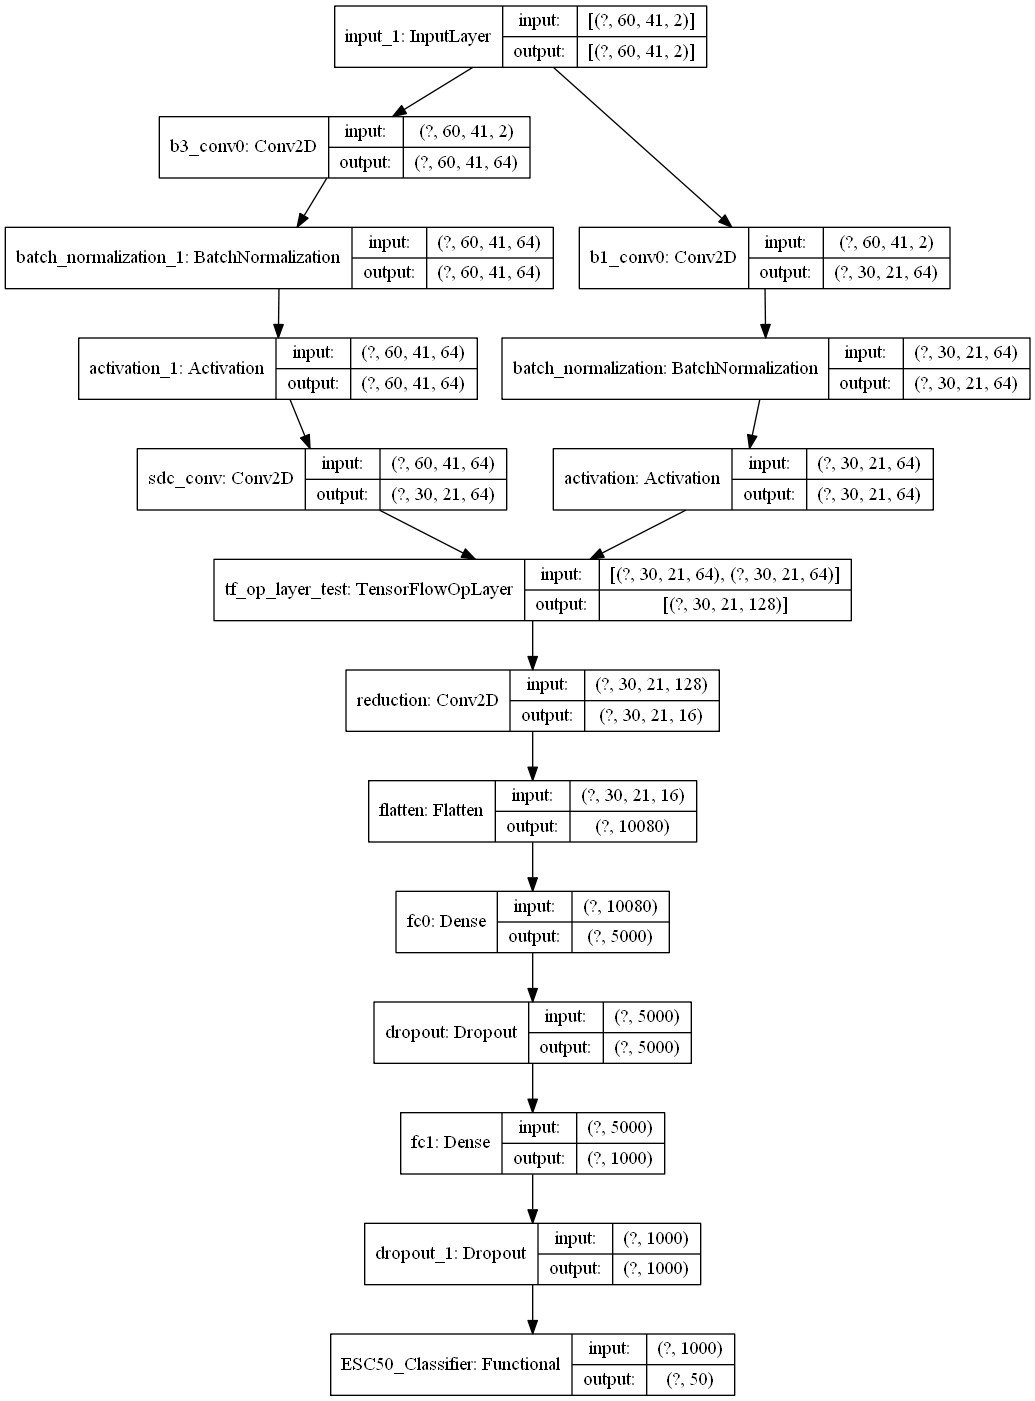

In [4]:
BackboneNet = BackBoneNet([60, 41, 2])
Classifier50 = ESC50Classifier([1000])

MFNet = Docking(BackboneNet, Classifier50)

print(MFNet.summary())

plot_model(MFNet, show_shapes=True, show_layer_names=True)

## Load Data

In [5]:
# Load
af1, alf1 = Load_Augmented(name='af1', path='Augmented_2/')
af2, alf2 = Load_Augmented(name='af2', path='Augmented_2/')
af4, alf4 = Load_Augmented(name='af4', path='Augmented_2/')
af5, alf5 = Load_Augmented(name='af5', path='Augmented_2/')

# Compute the features
f1_processed, lf1_processed = Preprocessing(af1, alf1)
f2_processed, lf2_processed = Preprocessing(af2, alf2)
f4_processed, lf4_processed = Preprocessing(af4, alf4)
f5_processed, lf5_processed = Preprocessing(af5, alf5)

100%|██████████| 2000/2000 [00:13<00:00, 151.25it/s]


In [6]:
# Generate training and validation set

training_dataset = CreateTrainingSet(f1_processed, f2_processed, f4_processed, lf1_processed, lf2_processed, lf4_processed)

validation_dataset = CreateValidationSet(f5_processed, lf5_processed)

In [7]:
opt = tf.keras.optimizers.Adam(lr=0.000001)
MFNet.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])

In [8]:
max_epochs = 50

epoch_loss= []
epoch_acc = []

epoch_vl = []
epoch_va = []

# Loop over the epochs
for epoch in range(max_epochs):
    
    # Shuffle the training
    training_dataset = training_dataset.shuffle(len(af1)*3)
    
    step_loss = []
    step_acc = []
    
    step_vl = []
    step_va = []
    
    start = time.time()
    # train over mini-batches
    for x_batch, y_batch in training_dataset:
        
        # train on batch
        step_stats = MFNet.train_on_batch(x_batch, y_batch)
        
        # save loss and accuracy
        step_loss.append(step_stats[0])
        step_acc.append(step_stats[1])
        
    # compute validation stats
    for x_batch, y_batch in validation_dataset:
        
        # compute validation stats
        val_stats = MFNet.test_on_batch(x_batch, y_batch)
        
        # save loss and accuracy
        step_vl.append(val_stats[0])
        step_va.append(val_stats[1])
    end = time.time()
        
    # Save the mean loss and accuracy of the entire epoch
    epoch_loss.append(np.mean(step_loss))
    epoch_acc.append(np.mean(step_acc))
    epoch_vl.append(np.mean(step_vl))
    epoch_va.append(np.mean(step_va))
    
    # Print epoch training stats
    print("Epoch %2d: \t t-loss: %3.6f \t t-acc: %.6f \t v-loss: %3.6f \t v-acc: %.6f \t time: %3.3f" % (epoch + 1, epoch_loss[-1], epoch_acc[-1], epoch_vl[-1], epoch_va[-1], (end - start)))

Epoch  1: 	 t-loss: 4.766349 	 t-acc: 0.024067 	 v-loss: 3.826119 	 v-acc: 0.042462 	 time: 63.208
Epoch  2: 	 t-loss: 4.078433 	 t-acc: 0.033731 	 v-loss: 3.790242 	 v-acc: 0.071437 	 time: 58.300
Epoch  3: 	 t-loss: 3.920430 	 t-acc: 0.042413 	 v-loss: 3.756284 	 v-acc: 0.086368 	 time: 55.308
Epoch  4: 	 t-loss: 3.822777 	 t-acc: 0.051651 	 v-loss: 3.716492 	 v-acc: 0.099190 	 time: 54.729
Epoch  5: 	 t-loss: 3.748375 	 t-acc: 0.064333 	 v-loss: 3.664374 	 v-acc: 0.107849 	 time: 54.312
Epoch  6: 	 t-loss: 3.685762 	 t-acc: 0.074904 	 v-loss: 3.619328 	 v-acc: 0.119449 	 time: 54.207
Epoch  7: 	 t-loss: 3.629970 	 t-acc: 0.081735 	 v-loss: 3.567341 	 v-acc: 0.130273 	 time: 53.940
Epoch  8: 	 t-loss: 3.579239 	 t-acc: 0.092880 	 v-loss: 3.547084 	 v-acc: 0.134381 	 time: 53.909
Epoch  9: 	 t-loss: 3.535500 	 t-acc: 0.101248 	 v-loss: 3.513875 	 v-acc: 0.142706 	 time: 53.897
Epoch 10: 	 t-loss: 3.489443 	 t-acc: 0.108968 	 v-loss: 3.473867 	 v-acc: 0.147258 	 time: 53.589
Epoch 11: 

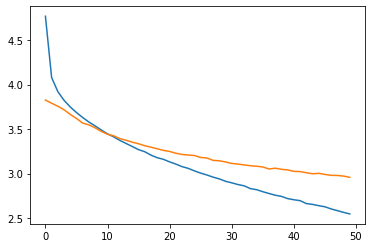

In [9]:
plt.figure()
plt.plot(epoch_loss)
plt.plot(epoch_vl)
plt.show()
plt.close('all')

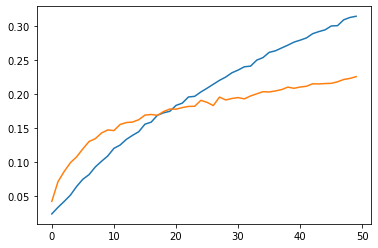

In [10]:
plt.figure()
plt.plot(epoch_acc)
plt.plot(epoch_va)
plt.show()
plt.close('all')